# Projet 4, Partie 2 - Construisez un modèle de scoring

Comme nous l'avons vu dans la partie 1 (voir notebook précedant) notre choix de modèle c'est porte sur les modèles ayant les meilleures metriques a savoir: 

- Linear Discriminant Analysis (LDA)
- LightGBM (LGB)
- Naive Bayes (NB)

Pourquoi ? 

- LDA a les meilleures performance global (AUC, F1, Kappa, MCC)
- LGB a la meilleure precision et une des meilleure Accuracy
- NB a le meilleures recall


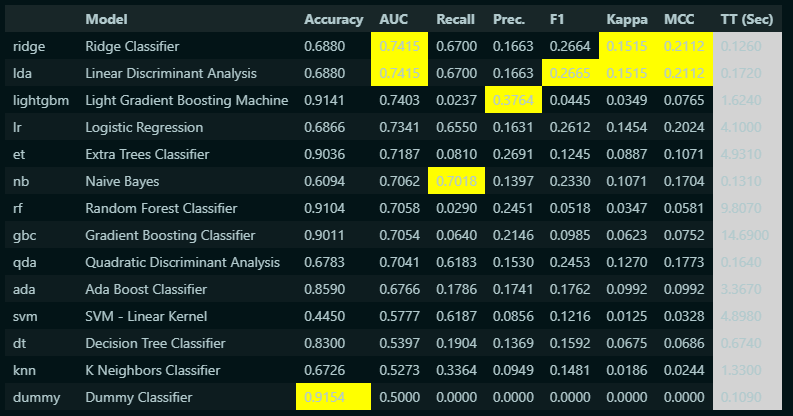

In [ ]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
import numpy as np
from sklearn.naive_bayes import MultinomialNB, GaussianNB  
from lightgbm import LGBMClassifier  
# import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from imblearn.over_sampling import SMOTE 
import optuna
import logging
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score

In [ ]:
df_origin = pd.read_csv('../data/application_train.csv')
df = df_origin.copy()

In [ ]:
class scoringCredit:
    def __init__(self, data , preprocessing_type: str):
        self.data = data
        self.preprocessing_type = preprocessing_type
        self.feature_importance_columns = None
        self.columns_without_context = [
            'SK_ID_CURR',
            'NAME_CONTRACT_TYPE',
            'NAME_TYPE_SUITE',
            'NAME_INCOME_TYPE',
            'NAME_EDUCATION_TYPE',
            'NAME_FAMILY_STATUS',
            'NAME_HOUSING_TYPE',
            'DAYS_ID_PUBLISH',
            'FLAG_EMP_PHONE',
            'FLAG_WORK_PHONE',
            'FLAG_PHONE',
            'FLAG_EMAIL',
            'DAYS_LAST_PHONE_CHANGE',
            'WEEKDAY_APPR_PROCESS_START'
        ]
        
    
    def handleMissingValues(self):
        try:
            # Calcul des valeurs manquantes par columns en %
            missing_percent_cols = (self.data.isna().sum() / len(self.data)) * 100

            # Crée une liste des colonnes ayant plus de 50% de valeurs manquantes
            drop_cols = missing_percent_cols[missing_percent_cols > 40]

            #  supressino des colonnes dans le dataframe
            self.data = self.data.drop(list(drop_cols.index), axis=1)

            # Recuperer toutes les colonnes qui ont encore des valeurs manquantes

            #Imputation avec knn imputer


            self.data = self.data.dropna()

            return self.data

        except Exception as error:
            raise error

        return f'Sucessfuly Delete: {list(drop_cols.index)}'


    def handleCategoricalsData(self):
        try:
            # Features Binaires
            binary_features = ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']

            # Traitement de CODE_GENDER pour supprimer xna
            if 'CODE_GENDER' in self.data.columns:
                self.data['CODE_GENDER'] = self.data['CODE_GENDER'].replace('XNA', pd.NA)

            # Convertir les variables binaires avec get_dummies
            self.data[binary_features] = pd.get_dummies(self.data[binary_features], drop_first=True).astype(int)

            # Features pour target encoding
            target_encoding_features = ['ORGANIZATION_TYPE', 'OCCUPATION_TYPE']
            for feature in target_encoding_features:
                if feature in self.data.columns:
                    target_mean = self.data.groupby(feature)['TARGET'].mean()
                    self.data[feature] = self.data[feature].map(target_mean)

            return self.data

        except Exception as error:
            raise error

        
    def featuresOptimisation(self):
        try:
            # Étape 1 : Colonnes FLAG
            flag_columns = self.data.filter(like='FLAG').columns
            self.data['FLAGS'] = self.data[flag_columns].sum(axis=1)
            self.data.drop(columns=flag_columns, inplace=True)

            # Étape 2 : Colonnes REGION
            region_columns = self.data.filter(like='REGION').columns.tolist()
            additional_region_columns = ['REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY']
            region_columns = [col for col in additional_region_columns if col in self.data.columns] + region_columns
            if region_columns:  # Assurer qu'il y a des colonnes à traiter
                self.data['REGION_SCORE'] = self.data[region_columns].sum(axis=1)
                self.data.drop(columns=region_columns, inplace=True)

            # Étape 3 : Calcul des ratios pour les colonnes AMT
            self.data['INCOME_CREDIT_RATIO'] = self.data['AMT_INCOME_TOTAL'] / self.data['AMT_CREDIT']
            self.data['ANNUITY_CREDIT_RATIO'] = self.data['AMT_ANNUITY'] / self.data['AMT_CREDIT']
            self.data['CREDIT_POSSESSION_RATIO'] = self.data['AMT_CREDIT'] / self.data['AMT_GOODS_PRICE']
            self.data['INCOME_ANNUITY_RATIO'] = self.data['AMT_INCOME_TOTAL'] / self.data['AMT_ANNUITY']

            # Étape 4 : Application de la PCA sur les colonnes AMT
            amt_columns = ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE']
            amt_columns = [col for col in amt_columns if col in self.data.columns]

            # Supprimer les lignes avec des valeurs manquantes uniquement dans amt_columns
            self.data.dropna(subset=amt_columns, inplace=True)

            # Normalisation des données et PCA
            if amt_columns: 
                scaler = StandardScaler()
                pca = PCA(n_components=1)
                self.data['AMT_PCA'] = pca.fit_transform(scaler.fit_transform(self.data[amt_columns]))

                        # Étape 5 : Traitement spécifique au mode 'TRAIN'
            if getattr(self, 'preprocessing_type', None) == 'TRAIN':

                # Étape 5 : Features Selection avec selctkbest

                # Supression des valeurs manquantes si presentes
                self.data = self.data.dropna()

                X = self.data.drop('TARGET', axis=1)
                y = self.data['TARGET']

                num_selector = SelectKBest(score_func=f_classif, k='all').fit(X, y)

                # Scores numériques
                scores = num_selector.scores_

                # Créer un dataframe pour seaborn
                feature_scores = pd.DataFrame({
                    'Feature': np.array(X.columns),
                    'Score': scores
                })

                # Sort les features par importance 
                feature_scores = feature_scores.sort_values(by='Score', ascending=False)

                # Return les 15 features les plus importantes
                self.feature_importance_columns = feature_scores[:15].Feature
            else:
                y = self.data.TARGET


            return self.data[self.feature_importance_columns], y

        except Exception as error:
            raise error
    

    def preprocessing(self):
        try:
            # Étape 1 : Supprimer les colonnes sans contexte métier
            self.data = self.data.drop(self.columns_without_context, axis=1, errors='ignore')

            # Étape 2 : Gestion des valeurs manquantes
            self.data = self.handleMissingValues()

            # Étape 3 : Gestion des données qualitatives
            self.data = self.handleCategoricalsData()

            # Étape 4 : Feature engineering & selection
            X, y = self.featuresOptimisation()

            return X, y

        except Exception as error:
            # Ajouter plus de contexte à l'erreur
            raise RuntimeError(f"Error in preprocessing step: {error}") from error


    def train(self, model, X_train, y_train, scale_pos_weight=None, is_unbalance=False):
        try:
            # Pour les modèles de type Naive Bayes
            if isinstance(model, GaussianNB):
                class_prior = [sum(y_train == i) / len(y_train) for i in sorted(set(y_train))]
                model.set_params(priors=class_prior)
                model.fit(X_train, y_train)
            elif isinstance(model, MultinomialNB):
                model.fit(X_train, y_train)  # Pas de priors supporté ici

            # Pour les modèles supportant le paramètre class_weight
            elif hasattr(model, 'class_weight'):
                model.set_params(class_weight='balanced')
                model.fit(X_train, y_train)

            # Pour LightGBM
            elif isinstance(model, LGBMClassifier):
                if is_unbalance:
                    model.set_params(is_unbalance=True)
                if scale_pos_weight:
                    model.set_params(scale_pos_weight=scale_pos_weight)
                model.fit(X_train, y_train)

            # Pour Linear Discriminant Analysis (LDA) 
            elif isinstance(model, LinearDiscriminantAnalysis):
                # Utilisation de SMOTE car ponderation non applicable a ce modèle
                smote = SMOTE(random_state=42)
                X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
                model.fit(X_train_res, y_train_res)

            else:
                raise ValueError("Unsupported model for balancing and training.")
            
            return model 

        except Exception as error:
            raise RuntimeError(f"Error in balancing and training model: {error}") from error
            

In [ ]:
from sklearn.metrics import (
    accuracy_score, f1_score, recall_score, precision_score, 
    cohen_kappa_score, matthews_corrcoef, roc_auc_score, roc_curve, 
    confusion_matrix
)

def displayMetrics(model, X_test, y_test):
    # Prédictions
    y_pred = model.predict(X_test)

    # Calcul des métriques
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    kappa = cohen_kappa_score(y_test, y_pred)
    mcc = matthews_corrcoef(y_test, y_pred)

    # Vérifier si c'est un problème de classification binaire pour l'AUC
    is_binary = len(np.unique(y_test)) == 2
    auc = roc_auc_score(y_test, y_pred) if is_binary else None

    # Affichage des métriques
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Cohen's Kappa: {kappa:.4f}")
    print(f"MCC: {mcc:.4f}")
    if is_binary:
        print(f"AUC: {auc:.4f}")
    else:
        print("AUC: Non applicable pour une classification multiclass")

    # Création des subplots
    fig, axes = plt.subplots(1, 2 if is_binary else 1, figsize=(16, 6))
    
    # Matrice de confusion
    cm = confusion_matrix(y_test, y_pred)
    classes = np.unique(y_test)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=axes[0], 
                xticklabels=classes, yticklabels=classes)
    axes[0].set_title("Matrice de confusion", fontsize=16)
    axes[0].set_xlabel("Prédictions", fontsize=12)
    axes[0].set_ylabel("Véritables classes", fontsize=12)
    
    # Courbe ROC pour les problèmes binaires
    if is_binary:
        fpr, tpr, _ = roc_curve(y_test, y_pred)
        axes[1].plot(fpr, tpr, label=f"ROC Curve (AUC = {auc:.2f})", color='blue')
        axes[1].plot([0, 1], [0, 1], linestyle='--', color='gray', label="Random Classifier")
        axes[1].set_xlim([0.0, 1.0])
        axes[1].set_ylim([0.0, 1.0])
        axes[1].set_xlabel("False Positive Rate (FPR)")
        axes[1].set_ylabel("True Positive Rate (TPR)")
        axes[1].set_title("ROC Curve", fontsize=16)
        axes[1].legend(loc="lower right")
    
    plt.tight_layout()
    plt.show()

    return y_pred


# Train

In [ ]:
from sklearn.model_selection import train_test_split

X = df.drop('TARGET', axis=1)
Y = df.TARGET

# Effectuer la division
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Concaténer X_train et y_train
df_train = pd.concat([X_train, y_train], axis=1)
df_test = pd.concat([X_test, y_test], axis=1)

print(X_test.shape, y_test.shape)
print(X_train.shape, y_train.shape)

In [ ]:
# initialiser la classe
SC = scoringCredit(df_train, 'TRAIN')

# Appliquer le preprocessing au df
X_train,y_train = SC.preprocessing()

In [ ]:
# Entrainement du modele LDA
LDA = SC.train(LinearDiscriminantAnalysis(), X_train, y_train)

In [ ]:
# Entrainement du modele LGM
LGM = SC.train(LGBMClassifier(), X_train, y_train)

In [ ]:
NB = SC.train(GaussianNB(), X_train, y_train)

## Test

In [ ]:
# Definir les nouveaux parametre de classe pour les données de test
SC.preprocessing_type = 'TEST'
SC.data = df_test
print(SC.preprocessing_type, len(SC.data.columns), SC.data.shape)

# Appliquer le preprocessing sur les données de test
X_test,y_test = SC.preprocessing()

# Afficher la taille de X et y
X_test.shape, y_test.shape

# Resultat LDA

In [ ]:
y_pred_lda = displayMetrics(LDA, X_test, y_test)

In [ ]:
# Calculer la courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_lda)

# Calculer l'AUC
auc = roc_auc_score(y_test, y_pred_lda)

sns.set_style("whitegrid")  # Style graphique avec seaborn

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc:.2f})", color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Random Classifier")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()


# Resultat LGM

In [ ]:
y_pred_lgm = displayMetrics(LGM, X_test, y_test)

# Resultat NB

In [ ]:
y_pred_nb = displayMetrics(NB, X_test, y_test)

Le modèle qui obtient les meilleures resultat est donc pour le moment LGM qui obtient les meilleures metrics, cependant ce n'est pas un modèle qui est très optimal et performant, nous allons donc passer a la deuxieme etape, l'optimisation des hyperparamètres pour voir si nous pouvons avoir une amelioration significative de notre modèle 

# Optimisation des hyperparametres

In [ ]:
# Fonction objective à optimiser
def objective(trial):
    param = {
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 50),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0)
    }

    model = LGBMClassifier(**param)
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='f1')
    return scores.mean()

# Configurer le logger d'Optuna pour limiter les logs
optuna.logging.set_verbosity(optuna.logging.WARNING)  # Limiter l'affichage des logs à WARNING

# Créer l'étude (study)
study = optuna.create_study(direction='maximize')

# Optimisation
study.optimize(objective, n_trials=20)

# Afficher les meilleurs paramètres
print("Best parameters:", study.best_params)


In [ ]:
# Entrainer le modèle avec les meilleurs params
lgb_optimized = SC.train(LGBMClassifier(**study.best_params), X_train=X_train, y_train=y_train) 



In [ ]:
y_pred_lda = displayMetrics(lgb_optimized, X_test, y_test)